In [1]:
import sys
#sys.path.append("fashion-clip/")
from fashion_clip.fashion_clip import FashionCLIP
import pandas as pd
import numpy as np
from collections import Counter
from PIL import Image
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression

In [2]:
fclip = FashionCLIP('fashion-clip')

In [3]:
%%capture
!pip install gdown
!gdown "1igAuIEW_4h_51BG1o05WS0Q0-Cp17_-t&confirm=t"
!unzip data

In [5]:
articles = pd.read_csv("data_for_fashion_clip/articles.csv")

# drop items that have the same description
subset = articles.drop_duplicates("detail_desc").copy()

# remove items of unkown category
subset = subset[~subset["product_group_name"].isin(["Unknown"])]

# FashionCLIP has a limit of 77 tokens, let's play it safe and drop things with more than 40 tokens
subset = subset[subset["detail_desc"].apply(lambda x : 4 < len(str(x).split()) < 40)]

# We also drop products types that do not occur very frequently in this subset of data
most_frequent_product_types = [k for k, v in dict(Counter(subset["product_type_name"].tolist())).items() if v > 10]
subset = subset[subset["product_type_name"].isin(most_frequent_product_types)]

# lots of data here, but we will just use only descriptions and a couple of other columns
subset.head(3)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,176754003,176754,2 Row Braided Headband (1),74,Hair/alice band,Accessories,1010016,Solid,17,Yellowish Brown,...,Hair Accessories,C,Ladies Accessories,1,Ladieswear,66,Womens Small accessories,1019,Accessories,Two-strand hairband with braids in imitation s...
3,189634031,189634,Long Leg Leggings,273,Leggings/Tights,Garment Lower body,1010016,Solid,93,Dark Green,...,Basic 1,D,Divided,2,Divided,51,Divided Basics,1002,Jersey Basic,Leggings in stretch jersey with an elasticated...


In [6]:
subset.to_csv("subset_data.csv", index=False)
f"There are {len(subset)} elements in the dataset"

'There are 3104 elements in the dataset'

In [7]:
images = ["data_for_fashion_clip/" + str(k) + ".jpg" for k in subset["article_id"].tolist()]
texts = subset["detail_desc"].tolist()

# we create image embeddings and text embeddings
image_embeddings = fclip.encode_images(images, batch_size=32)
text_embeddings = fclip.encode_text(texts, batch_size=32)

# we normalize the embeddings to unit norm (so that we can use dot product instead of cosine similarity to do comparisons)
image_embeddings = image_embeddings/np.linalg.norm(image_embeddings, ord=2, axis=-1, keepdims=True)
text_embeddings = text_embeddings/np.linalg.norm(text_embeddings, ord=2, axis=-1, keepdims=True)

100%|███████████████████████████████████████████| 97/97 [02:01<00:00,  1.25s/it]


Map:   0%|          | 0/3104 [00:00<?, ? examples/s]

100%|███████████████████████████████████████████| 97/97 [00:35<00:00,  2.77it/s]


In [18]:
from __future__ import annotations

import requests
import os
import json
from multiprocessing import Pool
from concurrent.futures import ThreadPoolExecutor

from PIL import Image
from matplotlib import pyplot as plt
import faiss
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [13]:
data_path = '/Users/jsb/repos/moodboard/data/asos/all_products_8799.json'

In [14]:
import json

with open(data_path, 'r') as fp:
    products = json.loads(fp.readline())

In [16]:
def images_to_embeddings(images: list[Image]) -> torch.tensor:
    """"""
    vembeds = fclip.encode_images(images)

    vembeds = vembeds / vembeds.norm(p=2, dim=-1, keepdim=True)
    
    return vembeds

In [60]:
class AsosClothingDataset(Dataset):
    """
    dataset found at https://data.world/promptcloud/amazon-fashion-products-2020/file/marketing_sample_for_amazon_com-amazon_fashion_products__20200201_20200430__30k_data.ldjson
    downloads dataset images fast with multithreading, and includes 
    category-specific subsetting for fast recommendation over a category
    """
    @staticmethod
    def read_records(fpath):
        records = []
        with open(fpath, 'r') as fp:
            for line in fp:
                records.append(json.loads(line))
        return records
    
    def _download(self, record):
        """download a single record"""
        md = None
        try:
            image_url = "https://" + record["imageUrl"]
            image_path = os.path.join(self.image_dir, str(record["id"]) + ".jpg")
            if not os.path.exists(image_path):
                image = Image.open(requests.get(image_url, stream=True).raw)
                image.save(image_path)

            label = f"a catalog photo of {record['name']}"
            
            category = "dress"

            md = {
                "product_id": record["id"],
                "image_path": image_path,
                "image_url": image_url,
                "label": label,
                "category": category,
            }
        except:
            print('failed')
            md = None

        return md

    @staticmethod
    def _thread_run(f, my_iter):
        """download all records using multithreading"""
        with ThreadPoolExecutor() as executor:
            results = list(tqdm(executor.map(f, my_iter), total=len(my_iter)))
        return results


    def __init__(self, image_dir: str, records: List[dict]):
        
        ids = [rec["id"] for rec in records]
        
        self.image_dir = image_dir
        
        os.makedirs(self.image_dir, exist_ok=True)
        
        # download images and return metadata
#         mds = []
#         for record in records:
#             md = self._download(record)
#             mds.append(md)
        
        mds = self._thread_run(self._download, records)
        mds = [md for md in mds if md is not None]
    
        self.metadata = pd.DataFrame(mds)
        self.metadata.set_index("product_id")
        self.metadata.sort_index()
        self.metadata.reset_index(drop=True)
        
    def __getitem__(self, idx: int) -> (Image, str, str):
        md = self.metadata.iloc[idx]
        
        try:
            image_path = md.image_path
        except:
            image_path = None

        return (image_path, md.label, md.category)
    
    def __len__(self,) -> int:
        return len(self.metadata)
    
    
    def get_category_indices(self, category: str) -> np.array:
        """return the indices of all products in this category"""
        md = self.metadata[self.metadata.category == category]
        return md.index

In [61]:
image_dir = "./TEST"

records = products

asos_dataset = AsosClothingDataset(image_dir=image_dir, records=records)

100%|█████████████████████████████████| 19545/19545 [00:00<00:00, 147981.88it/s]


In [29]:
def collate_fn(batch):
    images, labels, categories = [], [], []
    for item in batch:
        image, label, category = item
        # filter out any datapoints with corrupt images
        if image is not None:
            images.append(image)
            labels.append(label)
            categories.append(category)
    return images, labels, categories


data_loader = DataLoader(
    dataset = asos_dataset,
    collate_fn = collate_fn,
    batch_size = 32,
    shuffle = False,
)

In [33]:
for batch in data_loader:
    paths, labels, cats = batch
    encodings = fclip.encode_images(paths, 32)
    break

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.99it/s]


In [39]:
encodings = encodings/np.linalg.norm(encodings, ord=2, axis=-1, keepdims=True)

embeddings_path = os.path.join(image_dir, 'asos_embeddings_fashion.npy')

In [42]:
img_paths = asos_dataset.metadata.image_path

'./TEST/200604040.jpg'

In [43]:
if not os.path.exists(embeddings_path):
    candidate_vembeds = []

    count = 0
    # for imgs, labs, cats in tqdm(data_loader):
    #     count += len(imgs)
    with torch.no_grad():
        encodings = fclip.encode_images(img_paths, 32)
    candidate_vembeds = encodings/np.linalg.norm(encodings, ord=2, axis=-1, keepdims=True)

    #     candidate_vembeds.append(encodings)
    # candidate_vembeds = numpy.concatenate(candidate_vembeds)

    np.save(embeddings_path, candidate_vembeds)

candidate_vembeds = np.load(embeddings_path)

611it [05:16,  1.93it/s]                                                        


In [44]:
category_vembeds = candidate_vembeds
dim = category_vembeds.shape[1]
index = faiss.IndexFlatIP(dim)
index.add(category_vembeds)


def search(image_paths, texts, wimages, wtexts, index, k=10):
    with torch.no_grad():
        if image_paths:
            query_vembeds = fclip.encode_images(image_paths)
        else:
            query_vembeds = []
        if texts:
            query_tembeds = fclip.encode_text(texts)
        else:
            query_tembeds = []
        
    new_query = torch.zeros(512)
    for i in range(len(image_paths)):
        new_query += query_vembeds[i] * wimages[i]
    
    for i in range(len(texts)):
        new_query += query_tembeds[i] * wtexts[i]
        
    new_query = new_query / np.linalg.norm(new_query, ord=2, axis=-1, keepdims=True)

    dists, idxs = index.search(new_query, k)

    return dists, idxs

In [73]:
image_path1 = asos_dataset.metadata.image_path[58]
image_path2 = asos_dataset.metadata.image_path[10283]

image1 = Image.open(image_path1)
image2 = Image.open(image_path2)

image_url1 = "https://m.media-amazon.com/images/I/519NXKdynQL._SS200_.jpg"
image_url2 = "https://www.fashionnova.com/cdn/shop/products/08-19-22Studio3_RM_ON_15-43-29_25_DM2820A_Gold_1805_EH.jpg?v=1661191816"
image_url3 = "https://images.urbndata.com/is/image/Anthropologie/4130646420009_037_b?$an-category$&qlt=80&fit=constrain"
image1 = Image.open(requests.get(image_url1, stream=True).raw)
image2 = Image.open(requests.get(image_url2, stream=True).raw)


In [74]:
query = fclip.encode_images([image_url1, image_url2], 2)
query = query / np.linalg.norm(query, ord=2, axis=-1, keepdims=True)

k=10
dists, idxs = index.search(query, k)

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.44s/it]


In [75]:
idxs

array([[11329,  6822, 17972, 16290,  5256, 16490,  2963,  3641, 15544,
         3184],
       [10388, 10352, 10235, 10387, 10436, 12608,  9291, 18930, 10766,
        18700]])

In [76]:
asos_dataset[58]

('./TEST/204557919.jpg',
 'a catalog photo of Topshop bell sleeve ruched bust mini tea dress in zebra print',
 'dress')

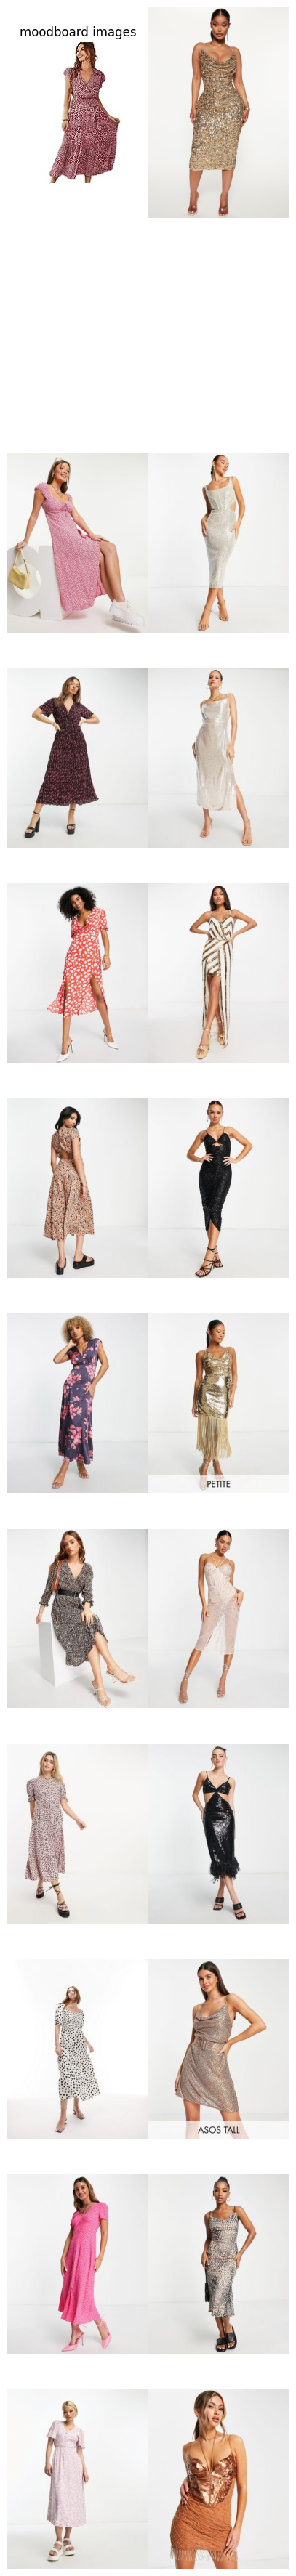

In [77]:
# plot
fig, axes = plt.subplots(1 + k, 2, 
                         figsize = (5, 50), 
                         gridspec_kw={'height_ratios': [3] + [1] * k,})

for ax in axes.ravel():
    ax.axis("off")
    
axes[0, 0].imshow(image1)
axes[0, 1].imshow(image2)
axes[0, 0].set_title("moodboard images")

i, j = 1, 0
for idx in idxs[0]:
    ax = axes[i, j]
    ax.imshow(Image.open(asos_dataset[idx][0]))
    ax.set_aspect("equal")
    i += 1

i, j = 1, 1
for idx in idxs[1]:
    ax = axes[i, j]
    ax.imshow(Image.open(asos_dataset[idx][0]))
    ax.set_aspect("equal")
    i += 1
    
plt.subplots_adjust(hspace=0.0, wspace = 0.0)
plt.show()